# Inverse Transform Sampling

It's great that Julia provides `rand()` and `randn()` to generate random values from a normal distribution. But:
- what if there is a distribution that is not available in Julia in a readily-available form such as `Normal(μ, σ)`?
- what if you are working in another computer language that does not have these utilities? 
- **most importantly**, what if we want to obtain draws from `Normal(μ, σ)` that are not necessarily random? (For instance, in the case of Monte Carlo integration.)

Here, we will delve into the details of drawing random samples from a given distribution. We will focus on the inverse transform sampling method.

In [2]:
using Interact
ui = button()
display(ui)

(div { className="field interact-widget" }
    (button { attributes=Dict{Any, Any}("data-bind" => "click: function (){this.clicks(this.clicks()+1)}, css: {'is-loading' : loading}") className="is-medium button is-primary" style=Dict{String, Any}() }
    "Press me!"))

In [4]:
using WebIO, Interact

px=widget(0:0.01:.3, label="px")
py=widget(0:0.01:.3, label="py")
plane = widget(Dict("x=0" => 1, "y=0" => 2), label="Section plane");

interactive_plot = map(px, py, plane)

# stack vertically
vbox(
    hbox(px, py, plane), # stack horizontally
    interactive_plot)

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["px"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(16), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), Asset("css", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), Asset("css", nothing, "/Users/xiang/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x000000010c52c330, Task (runnable) @0x000000010c52c330), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 4489392016, 4826872288)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.01\",\"0.02\",\"0.03\",\"0.04\",\

In [ ]:
node(:p, "Hello, Jupyter")

In [ ]:
using Blink: Window, body!
using Interact: @manipulate
using Plots: plot, plotlyjs
##

plotlyjs()
w = Window()
##

x = range(0, 6π; length=1000)
ui = @manipulate for i in 1:10
  plot(sin.(i .* x) .* cos.(i .* 2x))
end

body!(w, ui)

Need to understand:

- cumulative distribution function 
- inverse cumulative distribution function, also called the quantile function
- also, the probability density function

## Key Tools: CDF, Quantile Functions, and PDF


### Cumulative Distribution Function (CDF)

>>The CDF of a random variable $X$ returns the probability of $X$ being smaller than or equal to some value $x$.
$$\begin{align}
\Pr(X\leq x) = F_X(x).
\end{align}$$

We will use the simplified notation $F(x)$ instead of $F_X(x)$. For instance, $F(-1.64) = 0.05$ means that the probably that X falls below $X=-1.64$ is about 0.05.

### Quantile Function (sometimes referred to as the inverse CDF)

>> A quantile function is the inverse of a CDF.
$$\begin{align} 
F^{-1}(\alpha) = \inf\{x: F(x) \geq \alpha\}, \quad 0< \alpha < 1.
\end{align}$$

It reads: $F^{-1}(\alpha)$ returns the value of $x$ which is the smallest ("$\inf$") value of all the possible $x$ that makes the $x$'s CDF (i.e., $F(x)$) greater than or equal to $\alpha$.

In the case of a normally distributed random variable, we often use $\Phi()$ to denote the CDF.


[//]: # "Suppose $\Phi(x)$ is the CDF of a normally distributed random variable $X$ at $X=x$."


- $\Phi(x)$: The cumulative distribution function of $X$ at the value of $x$ ($X=x$).
  - $\Phi(x)=\alpha$: The cumulative distribution of $X$ at the value of $x$ is $\alpha$.
  - E.g., $\Phi(-1.64) = 0.05$: The cumulative distribution of $X$ at the value of $X=-1.64$ is $0.05$.


- $\Phi^{-1}(\alpha)$: The quantile function of $X$ at CDF=$\alpha$. 
  - $\Phi^{-1}(\alpha) = x$: The (normal) random variable's value at the variable's $\alpha$-quantile is $x$.
  - E.g., $\Phi^{-1}(0.05)=-1.64$: The normal random variable's 5% quantile is $-1.64$.
 

### Probability Density Function (PDF)

Given $F_X(x)$ being the CDF of a continuous random variable $X$ with the domain $-\infty \leq X \leq \infty$, the corresponding PDF is often denoted as $f_X(x)$ and defined by
\begin{aligned}
F_X(x) = \int_{-\infty}^x f_X(u) du.
\end{aligned}


- The graph of the PDF is a continuous versions of a histogram.


- It is sometimes called probability _distribution_ functions; not entirely wrong but should be avoided.


- The returned value is the _probability density_ or simply _density_, which is not a measure of _probability_:
  - $\phi(X=-1.64) = 0.10396$ is the "probability density" of $X$ at $X=-1.64$, which is not the "probability" of $X$ at $X=-1.64$. For a continuous random variable, the probability of $X=-1.64$ is 0!


- Instead, for a continuous random variable the probability is measured on a range, and the PDF could be used to measure the probability at the range.
  - The probability of $X$ in the range of $-1.6 \leq x \leq -1.5$ is 
  \begin{aligned}  
  \int_{-1.6}^{-1.5} f_X(u)du = \int_{-\infty}^{-1.5} f_X(u)du  - \int_{-\infty}^{-1.6} f_X(u)du = \Phi(-1.5) - \Phi(-1.6).
  \end{aligned}
  - Essentially, it is the size of the area under the PDF curve.
  - Since $X=-1.64$ is a point, and the size of this point's "area" under the PDF is 0, so the probability of $X=-1.64$ is 0.

### a quick comparison:

- probability density: $\phi(X=-1.64) = 0.10396$ (which is not the probability);
- probability of $X=-1.64$ is 0;
- cumulative distribution: $\Phi(X=-1.64) = 0.05$;
- quantile function: $\Phi^{-1}(0.05) = -1.64$;
- probability of $-1.641 \leq X \leq -1.639 $ is $\int_{-1.641}^{-1.639} \phi(u) du$, which is $\Phi(-1.639) - \Phi(-1.641)$.

In [ ]:
using Distributions

dist1 = Normal(0,1)

# probability density
@show pdf(dist1, -1.64)

# cumulative distribution
@show cdf(dist1, -1.64)

# quantile function
@show quantile(dist1, 0.05)

# probability in the range (-1.641, -1.639)
@show cdf(dist1, -1.639) - cdf(dist1, -1.641)


Now let's draw a graph that shows the relationship between PDF and CDF of a normally distributed random variable.

In [1]:
using Distributions, Interact, Plots, LaTeXStrings

x = range(-4, 4, length=500)
y = pdf.(Normal(0,1), x)

@manipulate for alpha in (0:0.025:1)    # alpha: significance level
  xi = round(quantile(Normal(0,1), alpha), digits=2)  # xi: corresponding x  # hjw
  x_shade = x .< xi
  plot(x[x_shade], y[x_shade], fillrange = zero(x[x_shade]), fc=:blues, label=L"\alpha=%$alpha")
  plot!(x, y, lc=:black, framestyle = :origin, xticks=[-4, xi, 4], 
        size = (650, 300), label=nothing)
  vline!([xi], color=:darkred, label=L"xi=%$xi")
end 

WebIO._IJuliaInit()

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["alpha"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(21), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), Asset("css", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), Asset("css", nothing, "/Users/xiang/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00000001074cea40, Task (runnable) @0x00000001074cea40), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 4427268112, 4296393056)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.025\",\"0.05\",\"0.075\",\"0.1\",\"0.125\",\"0.15\",\"0.175\",\"0.2\",\"0.225\",\"0.25\",\"0.275\",\"0.3\",\"0.325\",\"0.35\",\"0.3

In [3]:
using Distributions, Interact, Plots, LaTeXStrings, StatsPlots

d = Normal(0,1)

@manipulate for xi in (-4:0.025:4)   
  x_cdf = round(cdf(d, xi), digits=3)
  p1 = plot(d, framestyle=:origin, xticks=[xi], xlim=[-4,4], label="PDF", xlabel="X", lc=:black)
       vline!([xi], color=:darkred, label="xi", legend=:topleft)
  p2 = plot([xi,xi], [1.05,x_cdf], arrow=true, color=:darkred, label=L"xi=%$xi", ylim=[0,1])        
       plot!(x -> cdf(d, x), framestyle = :origin, xticks=[xi], xlim=[-4,4],
             yticks=[x_cdf], xlabel="X", label=L"\Phi(xi)",  lc=:black) 
       plot!([xi,0], [x_cdf,x_cdf], arrow=true, color=:orange, 
             label=L"\Phi(%$xi) = %$x_cdf", legend=:topleft, ylim=[0,1]) 
  plot(p1, p2, layout=(2,1))
end  


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["xi"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 321, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(161), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/xiang/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), Asset("css", nothing, "/Users/xiang/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), Asset("css", nothing, "/Users/xiang/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x0000000123144970, Task (runnable) @0x0000000123144970), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 143059011405)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-4.0\",\"-3.975\",\"-3.95\",\"-3.925\",\"-3.9\",\"-3.875\",\"-3.85\",\"-3.825\",\"-3.8\",\"-3.775\",\"-3.75\",\"-3.725\",\"-3.7\",\"-3.675\",\"-3.65\

## Use Quantile Functions to Draw Values from a Distribution

Recall that our goal is to draw a value $x$ from a random variable $X$ which follows a certain distribution. Since the quantile function is
\begin{aligned}
F^{-1}(\alpha) = x,
\end{aligned}
we could pick a value of $\alpha$, put it in the quantile function, and it will return $x$!

For instance, let's draw a value from a $N(0,1)$ distribution using $\alpha=0.05$. The Julia code is: 

In [ ]:
using Distributions

x1 = quantile(Normal(0,1), 0.05)  # could draw a vector as well
@show x1;

Note that since $\alpha$ is the cumulative distribution, which has the interpretation of **probability**, it is in the range of $(0, 1]$. It is true for _all_ distributions. Not only that, as we will see later, the value of $\alpha$ is _**uniformally distributed**_ in $(0, 1]$ for any continuous random variable.


Given the result, we could _**randomly**_ draw a value from the distribution using the `rand()` function. Using the normal distribution as an example:

In [ ]:
x2 = quantile(Normal(0,1), rand())  # what if you use rand(1) or rand(3)? See if for yourself
@show x2;

The above material may seem enough for us to use the inverse transformation sampling. However, as we shall see, we need one more theorem in order to fully justify the sampling method. It is called the _**probability integral transformation**_, or **PIT**. 

### Probability Integral Transformation

>> **Probability Integral Transformation (PIT):** Let $X$ be a continuous random variable that has a CDF $F_X(x)$ which is also continuous. Because $X$ is a random variable, $F_X(X)$ is also random. If we define a random variable $Y$ as $Y=F_X(X)$, then $Y \sim U(0,1)$.

In plain language: Values from a continuous random variable's CDF are uniformly distributed in (0,1).

There is a slight twist, though:


- If the CDF is the $X$'s CDF, the result is exact.

  - E.g.: If $X$ has a normal distribution and $\Phi_X(x)$ is the CDF of a normal random variable, then $Y=\Phi_X(X)$ would be exactly $U(0,1)$.


- If the CDF is not $X$'s CDF, the result may not be true.
 
  - E.g.: If $Z$ has a uniform distribution (which is bouned) and $\Phi_X(X)$ is the CDF of a normal random variable, then $Y=\Phi_X(Z)$ would not be $U(0,1)$ even in large samples.

  - E.g.: If $Z$ has a $t$ distribution and $\Phi_X(X)$ is the CDF of a normal random variable, then $Y=\Phi_X(Z)$ would be $U(0,1)$ only in large samples.



The PIT is widely used in statistics, econometrics, and data science. 
- In some applications, the emphasis is on transforming a random variable $X$ into a $Y \sim U(0,1)$. For instance, we may develop a statistical test that is defined on $U(0,1)$, and such a test may be applied to any $X$ by transforming $X$ into $Y\sim U(0,1)$.
- In other applications, the emphasis is on using a uniform random variable $Y \sim U(0,1)$ to generate $X$ that has the distribution function $F_X(x)$. The *inverse transformation sampling* is such an example.

### Draw Random Values

Now we have all the tools to do the inverse transformation sampling.


- Recall that a CDF function takes as input some value $x$ and tells you what is the probability of obtaining $X\leq x$. So,

$$ F(x) = p.$$


- PIT tells us that $p\in P$ has a $U(0,1)$ distribution.


- As for the quantile function, which is also called the inverse CDF of $X$, it would take $p$ as input and return $x$:

$$F^{-1}(p) = x.$$

So, it is easy to sample values from $X$: Since $P\sim U(0,1)$, we draw values $p$ from $U(0,1)$, pass them through $F^{-1}(p)$ and get $x$ which would has the distribution of $F(x)$.


In [ ]:
# using Distributions, Plots, StatsPlots
# experiment

d = Normal(0,1)

x = range(-4, 4, length=500)
y = pdf.(Normal(0,1), x)

@manipulate for ui in (0:0.01:1)         # CDF  
  xi = round(quantile(d, ui), digits=3)  # inverse CDF  # hjw
  x_shade = x .< xi  
  p3 = plot([0,xi], [ui,ui], arrow=true, color=:orange, label=L"U(0,1)=%$ui") 
       plot!(x -> cdf(d, x), framestyle=:origin, xticks=[xi], xlim=[-4,4],
             yticks=[0, ui, 1], label=L"\Phi(x)", xlabel="xi", lc=:black)   
       plot!([xi,xi], [ui+0.05,0], arrow=true, color=:darkred, 
             label=L"\Phi^{-1}(%$ui) = %$xi", legend=:topleft)                 
  p4=plot(x[x_shade], y[x_shade], fillrange = zero(x[x_shade]), fc=:blues, 
          label=L"ui=%$ui")
  plot!(x, y, lc=:black, framestyle = :origin, xticks=[-4, xi, 4], 
        label=nothing)
  vline!([xi], color=:darkred, label=L"\Phi^{-1}(%$ui) = %$xi")
  plot(p3, p4, layout=(2,1), size=(700,500))
end   

> **_NOTE:_** The interactive plot may sometimes become unresponsive, meaning that dragging the bar does not change the graph. This issue can usually be resolved by clearing all outputs and restarting the kernel. Follow these steps to do so:
>
> 1. In the menu, go to `Cell` > `All Output` > `Clear`.
> 2. Save the notebook.
> 3. Then, in the menu, select `Kernel` > `Restart & Run All`.




###### Example (simulating an exponential random variable)

We show how to generate random variables that has an exponential distribution with mean $\tau$.

An exponential random variable $X$ with the PDF of $f(x, \lambda) = \frac{1}{\lambda} e^{-\frac{1}{\lambda} x}$ has the mean and the standard deviation both equal to $\lambda$. Let's assume $\lambda=1$ so that the mean and the standard deviation of $X$ are both $1$. 

The corresponding CDF is $F(x) = 1-e^{-x}$. 

Now, what would be the quantile function? Recall that the quantile function $F^{-1}(p)$ would return a value of $x$ such that 

$$\begin{align}
1-e^{-x}=p.
\end{align}$$
According to PIT, $p\in P$ is $U(0,1)$. 

Solving for $x$, we have

$$\begin{align}
x = -\ln(1-p).
\end{align}$$

Thus,

$$\begin{aligned}
F^{-1}(p) = -\ln(1-p)
\end{aligned}$$

would generate an exponential random variable with mean equal to $1$.

Note that because $P \sim U(0,1)$, we have $1-P \sim U(0,1)$ as well. Therefore, the term `(1-p)` in the above equation could be replaced by `p` since both of them are uniform random variables in (0,1). That is, we could also use the following function to generate values from an exponential distribution with mean and standard deviation equal to 1:

$$\begin{aligned}
\mathrm{dgp}\_\mathrm{expo}(p) = -\ln(p).
\end{aligned}$$

How do we go from here to draw exponentially distributed random values with mean equal to $\tau$? Since $\tau X$ is exponential with mean $\tau$ if $X$ is exponential with mean $1$, it follows that $-\tau\ln(p)$ is exponential with mean $\tau$.


Let's do an example where we draw random numbers from an exponential distribution with mean equal to 0.8. Here is the Julia code.

In [ ]:
# do a simple demo here; testing the mean and the std.dev.

# using Statistics

aa = -log.(rand(10000))

@show [mean(aa) std(aa)]

bb = 0.8*aa
@show [mean(bb) std(bb)]

### Transform the data from $X$ distribution to $Z$ distribution

Now suppose you want to transform a random variable $X$ from a distribution to a totally different distribution. How would you do that? Intuitively, the procedure is 

$$\begin{align}
 X \rightarrow \mbox{Uniform} \rightarrow Z.
\end{align}$$

The first arrow is by way of the CDF of $X$, and the second arrow is via the quantile function of $Z$.

In the following example, we demonstrate how to transform a variable $X \sim F_X(X)$ (e.g., a normal random variable) to $Z \sim F_Z(Z)$ (e.g., an exponential random variable).

We do in the following steps:
- take a random sample `X` of $n$ measurements from $N(1,2)$;
  - draw a histogram of `X` and compare it to a $N(1,2)$;
- transform `X` to `Y ~ U(0,1)` using the CDF;
  - draw a histogram of `Y` and compare it to a $U(0,1)$;
- transform `Y` to `Z ~ Exp(2)` (where mean=standard deviation=2) using an appropriate quantile function;
  - draw a histogram of `Z` and compare it to a Exp$(2)$.

In [ ]:
using Statistics
d_N12 = Normal(1, sqrt(2))      # Normal(mean, std.dev)
n = 5_000;
X = randn(n)*sqrt(2) .+ 1   # may add rng; discuss the issue of random seed  # hjw
[mean(X) var(X)] |> display

histogram(X, normalize=true, bins=100)
plot!(d_N12)

In [ ]:
# transform X to Y~U(0,1)
Y  = cdf(d_N12, X)

histogram(Y, normalize=true, bins=100)
plot!(Uniform(0,1))


In [ ]:
d_E2 = Exponential(2)
Z = quantile(d_E2, Y)  # should also try manully coding the quantile function
[mean(Z) std(Z)] |> display

histogram(Z, normalize=true, bins=100)
plot!(d_E2)

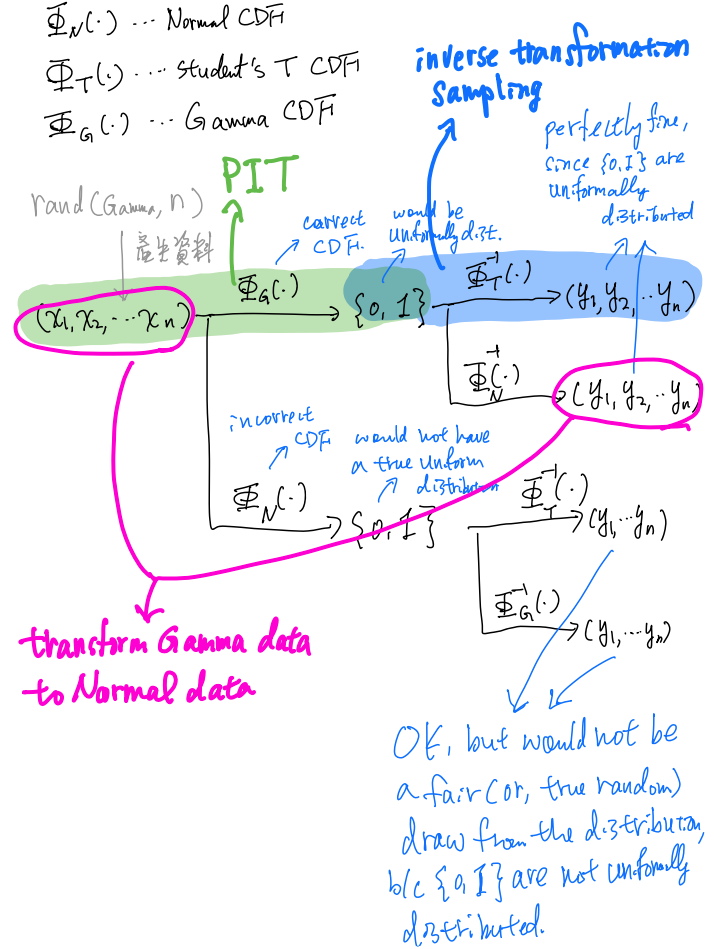